### Собственно что это?

Как говорится не сломаешь не поймешь: используя знания от безусловной генерации я хочу попробовать придумать условную генерацию по метке но только уже свою

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pandas as sns
import numpy as np
import matplotlib.pyplot as plt

import kagglehub
import idx2numpy
import os

### Загрузка и нормализация данных

In [118]:
def read_mnist():
    path = kagglehub.dataset_download("hojjatk/mnist-dataset")
    print("Путь до данных:", path)

    train_images_path = os.path.join(path, 'train-images.idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels.idx1-ubyte')
    test_imaages_path = os.path.join(path, 't10k-images.idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels.idx1-ubyte')
    
    X_train = idx2numpy.convert_from_file(train_images_path)
    y_train = idx2numpy.convert_from_file(train_labels_path)
    X_test = idx2numpy.convert_from_file(test_imaages_path)
    y_test = idx2numpy.convert_from_file(test_labels_path)

    print(f'Загружено тренировочных картинок: {len(X_train)}')
    print(f'Загружено тренировочных меток: {len(y_train)}')
    print(f'Загружено тестовых картинток: {len(X_test)}')
    print(f'Загружено тестовых меток: {len(y_test)}')
    
    return X_train, X_test, y_train, y_test

In [119]:
X_train, X_test, y_train, y_test = read_mnist()

Путь до данных: C:\Users\panika\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1
Загружено тренировочных картинок: 60000
Загружено тренировочных меток: 60000
Загружено тестовых картинток: 10000
Загружено тестовых меток: 10000


In [120]:
def normalize_data(X):
    X_zero_one = X / 255.0
    X_minus_one_one = (X_zero_one - 0.5) * 2.0
    return X_minus_one_one

batch_size = 128
X = torch.tensor(X_train, dtype=torch.float32)
X_norm = normalize_data(X)
X_batch = X_norm.view(-1, 1, 28, 28)

y = torch.tensor(y_train, dtype=torch.float32)

dataset = TensorDataset(X_batch, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

### Задание начальных условий и функций ембедингов и шума

In [121]:
timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

In [122]:
def q_sample(x_start, t, alphas_cumprod, noise):  
    """
    Add noise to x_start
    Args:
        x_start: [Batch, canals, W, H]
        t: [B,]
        alphas_cumprod: array of alphas
        noise: [Batch, canals, W, H] ~ N(0, I)
    """
    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def time_embedding(t, dim):
    """
    n = dim
    t -> {sin(w1*t), cos(w1*t), ... sin(wn*t), cos(wn*t)}
    Args:
        t: [B, ]
        dim: scalar
    """
    idx = torch.arange(0, dim // 2, device=t.device)
    w = 1 / (10000 ** ((2 * idx) / dim))
    angles = t[:, None] * w[None, :]
    sin = torch.sin(angles)
    cos = torch.cos(angles)
    return torch.cat([sin, cos], dim=-1)


def label_embedding(x, dim, num_classes=10):
    one_hot_plotting = torch.zeros(x.shape[0], num_classes, device=x.device)
    idx = torch.arange(0, x.shape[0], device=x.device)
    one_hot_plotting[idx, x.int()] = 1
    one_hot_plotting = one_hot_plotting.view(x.shape[0], 1, -1)
    v = F.interpolate(one_hot_plotting, size=dim, mode='linear', align_corners=False)
    return v.view(x.shape[0], dim)

def time_label_embedding(t, y, dim):
    v = (1000 * y + t) / 10
    idx = torch.arange(0, dim // 2, device=t.device)
    w = 1 / (10000 ** ((2 * idx) / dim))
    angles = v[:, None] * w[None, :]
    sin = torch.sin(angles)
    cos = torch.cos(angles)
    return torch.cat([sin, cos], dim=-1)

### Собственно какие идеи у меня?

Мне очень нравится идеи с тем, что аддитивно добавляя время картинка перемещается в свою область. Очевидно, я буду отображать метку в какой то вектор, а после добавлять также аддитивно (хотя можно и мультипликативно), но есть мысль, что если два раза пройтись ReLu(Conv(Relu(Conv(x)) + t)), то может быть проблема того, что информация просто потеряется и хотелось бы научиться это делать параллельно

Пусть f: t $\rightarrow$ v отображение времени в вектор. Есть крутая идея того, что все векторы при t $\in$ [0, 1000] f(t) не образует полноценный базис и метку отобразить в ортогональное дополнение и передвигать в тэтом направлении но это слишком сложно

### Идея 1

Можно попробовать просто добавить один слой

y - метка

h = ReLU(Conv(x)) \
h = ReLU(Conv(h + y)) \
h = ReLU(Conv(h + t))

In [123]:
class Unet1(nn.Module):
    class Block(nn.Module):
        def __init__(self, in_ch, out_ch, v_dim):
            super().__init__()
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
            self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
            self.mlp = nn.Linear(v_dim, out_ch)
            self.relu = nn.ReLU()

        def forward(self, x, time_embedding, label_embedding):
            v1 = self.mlp(label_embedding).view(label_embedding.shape[0], -1, 1, 1)
            v2 = self.mlp(time_embedding).view(time_embedding.shape[0], -1, 1, 1)
            
            h = self.relu(self.conv1(x))
            h = self.relu(self.conv2(h + v1))
            h = self.relu(self.conv3(h + v2))

            if x.shape[1] == h.shape[1]:
                return x + h
            return h

    def __init__(self, v_dim):
        super().__init__()
        self.v_dim = v_dim
        self.init_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        self.down1 = Unet1.Block(64, 64, v_dim)
        self.to_128 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        self.down2 = Unet1.Block(128, 128, v_dim)
        self.to_256 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        self.bottleneck = Unet1.Block(256, 256, v_dim)
        
        self.up_to_14 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.up_block1 = Unet1.Block(384, 128, v_dim)

        self.up_to_28 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.up_block2 = Unet1.Block(192, 64, v_dim)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t, y):
        t_emb = time_embedding(t, self.v_dim)
        y_emb = label_embedding(y, self.v_dim)

        x = self.init_conv(x)

        s1 = self.down1(x, t_emb, y_emb)
        x = self.to_128(s1)

        s2 = self.down2(x, t_emb, y_emb)
        x = self.to_256(s2)

        x = self.bottleneck(x, t_emb, y_emb)

        x = self.up_to_14(x)
        x = torch.cat([x, s2], dim=1)
        x = self.up_block1(x, t_emb, y_emb)

        x = self.up_to_28(x)
        x = torch.cat([x, s1], dim=1)
        x = self.up_block2(x, t_emb, y_emb)

        return self.final_conv(x)

In [124]:
%%time

device = "cuda" if torch.cuda.is_available() else "cpu"
time_dim=128
model = Unet1(time_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

epochs = 10

alphas_cumprod_device = alphas_cumprod.to(device)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_data, batch_labels in train_loader:
        x0 = batch_data.to(device)
        y0 = batch_labels.to(device)
        t = torch.randint(0, timesteps, (x0.shape[0],), device=device)
        real_noise = torch.randn_like(x0).to(device)
        
        xt = q_sample(x0, t, alphas_cumprod_device, real_noise)

        predicted_noise = model(xt, t, y0)
        loss = torch.nn.functional.mse_loss(predicted_noise, real_noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    torch.cuda.synchronize()
    print(f'Эпоха {epoch}: Loss MSE: {epoch_loss / len(train_loader)}')

Эпоха 0: Loss MSE: 0.1145358065139256
Эпоха 1: Loss MSE: 0.03740405052630251
Эпоха 2: Loss MSE: 0.032052613608141954
Эпоха 3: Loss MSE: 0.029176288310176275
Эпоха 4: Loss MSE: 0.02823410628399234
Эпоха 5: Loss MSE: 0.026724883480303323
Эпоха 6: Loss MSE: 0.026033296188248244
Эпоха 7: Loss MSE: 0.025374570732384222
Эпоха 8: Loss MSE: 0.02513264711779445
Эпоха 9: Loss MSE: 0.024923763899152466
CPU times: total: 10min 35s
Wall time: 10min 37s


### Идея 2

Изначально функция f является отображнием f: t $\rightarrow$ v. Можно представить это как отображение от 2 скаляров f: (y, t) $\rightarrow$ v

In [125]:
class Unet2(nn.Module):
    class Block(nn.Module):
        def __init__(self, in_ch, out_ch, emb_dim):
            super().__init__()
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
            self.time_mlp = nn.Linear(emb_dim, out_ch)
            self.relu = nn.ReLU()

        def forward(self, x, bias):
            v = self.time_mlp(bias).view(bias.shape[0], -1, 1, 1)

            h = self.relu(self.conv1(x))
            h = self.relu(self.conv2(h + v))

            if x.shape[1] == h.shape[1]:
                return x + h
            return h
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.init_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        self.down1 = Unet2.Block(64, 64, dim)
        self.to_128 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        self.down2 = Unet2.Block(128, 128, dim)
        self.to_256 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        self.bottleneck = Unet2.Block(256, 256, dim)

        self.up_to_14 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.up_block1 = Unet2.Block(384, 128, dim)

        self.up_to_28 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.up_block2 = Unet2.Block(192, 64, time_dim)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, time, label):
        vec = time_label_embedding(time, label, self.dim)

        x = self.init_conv(x) 

        s1 = self.down1(x, vec)
        x = self.to_128(s1)

        s2 = self.down2(x, vec)
        x = self.to_256(s2)

        x = self.bottleneck(x, vec)

        x = self.up_to_14(x)
        x = torch.cat([x, s2], dim=1)
        x = self.up_block1(x, vec)

        x = self.up_to_28(x)
        x = torch.cat([x, s1], dim=1)
        x = self.up_block2(x, vec)

        return self.final_conv(x)

In [127]:
%%time

device = "cuda" if torch.cuda.is_available() else "cpu"
time_dim=128
model2 = Unet2(time_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

epochs = 10

alphas_cumprod_device = alphas_cumprod.to(device)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_data, batch_labels in train_loader:
        x0 = batch_data.to(device)
        y0 = batch_labels.to(device)
        t = torch.randint(0, timesteps, (x0.shape[0],), device=device)
        real_noise = torch.randn_like(x0).to(device)
        
        xt = q_sample(x0, t, alphas_cumprod_device, real_noise)

        predicted_noise = model(xt, t, y0)
        loss = torch.nn.functional.mse_loss(predicted_noise, real_noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    torch.cuda.synchronize()
    print(f'Эпоха {epoch}: Loss MSE: {epoch_loss / len(train_loader)}')

Эпоха 0: Loss MSE: 0.025845285433568933
Эпоха 1: Loss MSE: 0.023861196515624964
Эпоха 2: Loss MSE: 0.02351198234021473
Эпоха 3: Loss MSE: 0.02341788082417331
Эпоха 4: Loss MSE: 0.02335634287685029
Эпоха 5: Loss MSE: 0.023097243505532047
Эпоха 6: Loss MSE: 0.023222255679383588
Эпоха 7: Loss MSE: 0.022846662639967923
Эпоха 8: Loss MSE: 0.022769190521954474
Эпоха 9: Loss MSE: 0.02300697408997809
CPU times: total: 10min 33s
Wall time: 10min 41s


### Всякий мусор

In [128]:
for b in train_loader:
    print(b[0].shape)
    print(b[1].shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [129]:
for a, b in train_loader:
    label_embedding(b, 12)
    break

In [130]:
for x, y in train_loader:
    t = torch.randint(0, timesteps, (x.shape[0],))
    time_label_embedding(t, y, 10)
    break

In [131]:
label = 3
dim = 128
a = torch.tensor([0] * 9, dtype=torch.float32)
a[label] = 1
a = a.view(1, 1, -1)
foo = F.interpolate(a, size=dim, mode='linear', align_corners=False)
foo = foo.view(dim)
foo

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0664, 0.1367, 0.2070, 0.2773, 0.3477, 0.4180, 0.4883, 0.5586, 0.6289,
        0.6992, 0.7695, 0.8398, 0.9102, 0.9805, 0.9492, 0.8789, 0.8086, 0.7383,
        0.6680, 0.5977, 0.5273, 0.4570, 0.3867, 0.3164, 0.2461, 0.1758, 0.1055,
        0.0352, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

### Генерация

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sqrt_inv_alphas = 1 / torch.sqrt(alphas)
coeff = (1 - alphas) / torch.sqrt(1 - alphas_cumprod)

amount = 10

@torch.no_grad()
def generate_digit(model):
    model.eval()
    img = torch.randn((amount, 1, 28, 28), device=device)
    labels = torch.arange(0, 10, device=device)
    
    for t_idx in reversed(range(timesteps)):
        t_tensor = torch.full((amount,), t_idx, device=device, dtype=torch.long)
        
        pred_noise = model(img, t_tensor, labels)
        img = sqrt_inv_alphas[t_idx] * (img - coeff[t_idx] * pred_noise)
        
        if t_idx > 0:
            z = torch.randn_like(img)
            img = img + torch.sqrt(betas[t_idx]) * z
            
    img = (img.clamp(-1, 1) + 1) / 2
    return img.cpu().numpy().squeeze()

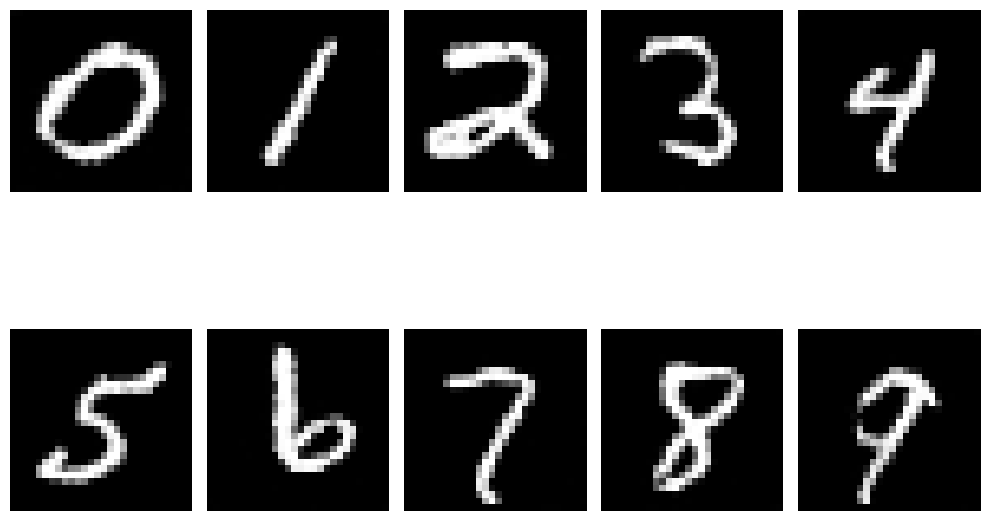

In [133]:
generated_imgs = generate_digit(model)

fig, axs = plt.subplots(2, 5, figsize=(10, 8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(generated_imgs[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

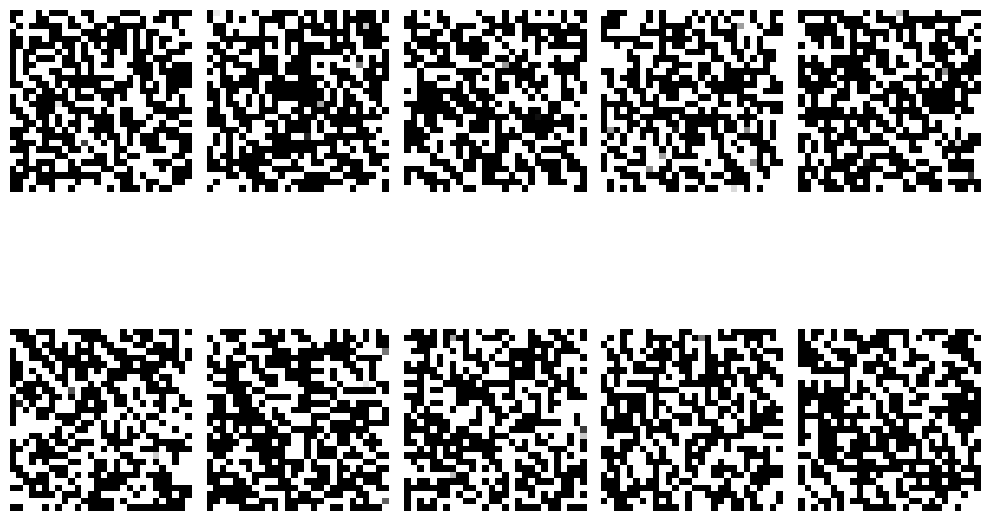

In [134]:
generated_imgs = generate_digit(model2)

fig, axs = plt.subplots(2, 5, figsize=(10, 8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(generated_imgs[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Результат

Из плюсов можно отметить, что хорошо осознанная основа диффузионных моделей, понимание 